In [151]:
import torch 
import random
import matplotlib 
import pandas as pd
import seaborn as sns

In [152]:
training_data = pd.read_csv('raw_data')
training_data = training_data[['X','Y']]

In [153]:
length = len(training_data)
print(length)

split_idx = int(length*0.8)
train_df, test_df = training_data.iloc[0:split_idx],training_data.iloc[split_idx:]
train_df, test_df

100000


(               X            Y
 0      47.078481  2213.642912
 1     -35.161041  1232.615629
 2     -92.432328  8544.235038
 3      91.685585  8408.333878
 4     -84.334414  7113.831739
 ...          ...          ...
 79995  13.534022   183.358207
 79996 -39.432332  1553.499318
 79997 -93.022916  8654.489340
 79998 -43.231394  1868.115244
 79999  58.693014  3443.986299
 
 [80000 rows x 2 columns],
                X            Y
 80000 -23.171492   537.642108
 80001  60.942869  3717.979997
 80002 -66.142316  4374.451430
 80003  96.191029  9255.107623
 80004 -70.196836  4926.339914
 ...          ...          ...
 99995 -66.330127  4401.284417
 99996   3.066864     6.030596
 99997 -10.727439   116.041919
 99998 -50.401224  2538.491824
 99999  68.310960  4669.491840
 
 [20000 rows x 2 columns])

In [154]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader 

In [155]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")
X, Y = torch.tensor(train_df['X'].to_numpy(), dtype=torch.float32), torch.tensor(train_df['Y'].to_numpy(), dtype=torch.float32)
loader = DataLoader(TensorDataset(X,Y), batch_size=20, shuffle=True)

In [156]:
class nikkisfirstMLP(nn.Module):
    def __init__(self, d_in:int, d_hidden:int, d_out:int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, d_hidden),
            nn.ReLU(),
            nn.Linear(d_hidden, d_hidden),
            nn.ReLU(),
            nn.Linear(d_hidden, d_out)
            )
        
    def forward(self, x):
        return self.net(x)


In [157]:
model = nikkisfirstMLP(d_in=1,d_hidden=10,d_out=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=1e-3)


for epoch in range(40):
    model.train()
    total_loss = 0

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        xb = xb.unsqueeze(1)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out,yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()*xb.size(0)

    print(f"epoch {epoch+1}: loss={total_loss:.4f}")

/Users/nikhileshbelulkar/opt/miniconda3/envs/fingers_crossed/lib/python3.11/site-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 1: loss=979495345310.0000
epoch 2: loss=869003428735.0000
epoch 3: loss=790012680840.0000
epoch 4: loss=716162935530.0000
epoch 5: loss=713305887772.5000
epoch 6: loss=713133041705.0000
epoch 7: loss=713258769250.0000
epoch 8: loss=712928739235.0000
epoch 9: loss=713110359160.0000
epoch 10: loss=713086331615.0000
epoch 11: loss=713239851130.0000
epoch 12: loss=712903839545.0000
epoch 13: loss=713106669105.0000
epoch 14: loss=713126889630.0000
epoch 15: loss=713127471625.0000
epoch 16: loss=713076357015.0000
epoch 17: loss=713218749875.0000
epoch 18: loss=713170052165.0000
epoch 19: loss=713018840625.0000
epoch 20: loss=713063392165.0000
epoch 21: loss=713129554360.0000
epoch 22: loss=712939663295.0000
epoch 23: loss=713095407485.0000
epoch 24: loss=713144375045.0000
epoch 25: loss=713146394475.0000
epoch 26: loss=713021174540.0000
epoch 27: loss=713059166815.0000
epoch 28: loss=713146761035.0000
epoch 29: loss=713008253255.0000
epoch 30: loss=713062722465.0000
epoch 31: loss=7131

In [158]:
preds = []

test_X, test_Y = torch.tensor(test_df['X'].to_numpy(), dtype=torch.float32), torch.tensor(test_df['Y'].to_numpy(), dtype=torch.float32)


model.eval()
with torch.no_grad():
    for tx in test_X:
        tx = tx.view(1, 1).to(device)                        # shape (1,1)
        y_hat = model(tx)
        pred = y_hat.cpu().numpy()[0][0]
        preds.append(pred)

In [159]:
output_df = pd.DataFrame({'X':list(test_X.numpy()),'Y':preds})

In [160]:
output_df

,X,Y
0,-23.171492,3186.060547
1,60.942867,3360.691650
2,-66.142319,3379.084961
3,96.191032,3692.272705
4,-70.196838,3403.301758
...,...,...
19995,-66.330124,3380.206543
19996,3.066864,3166.750732
19997,-10.727440,3176.902588
19998,-50.401226,3285.066650


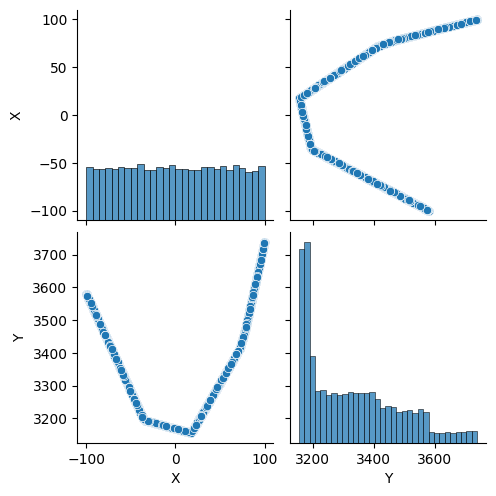

In [161]:
sns.pairplot(output_df)

In [162]:
#outside of the range of training data can we generalize well?

new_x = []


for _ in range(10_000):
    new_num = random.random()*100000*random.choice([-1,1])
    if abs(new_num)>10_000:
        new_x.append(new_num)

new_x

[-35068.966371446855,
 52559.36201587911,
 54752.636971863234,
 12803.10036866127,
 -73993.57607142517,
 -56607.729907189154,
 39167.53965173316,
 15709.887652249156,
 29007.64288822869,
 -63002.706888069995,
 -30628.805979198136,
 15871.230984539698,
 -43429.577112071216,
 -32189.681865260776,
 -70295.85787362276,
 -67863.6155064786,
 50507.40509558463,
 -40053.867119580835,
 50318.92628895456,
 -54912.75859587994,
 -20214.900972885753,
 55831.15331555344,
 41229.2888801239,
 -44104.52062736021,
 -78337.93792050138,
 -98121.49782800667,
 -96006.4681438073,
 -57690.73432673768,
 10829.70458755601,
 67237.66386299056,
 -45459.30810772964,
 38272.55940853925,
 -97039.56491674305,
 -41959.7921123461,
 90511.38865286896,
 83744.75528121082,
 -68042.6717164997,
 -12995.500469195209,
 -14794.695857255536,
 64333.23903002228,
 70202.7409924022,
 -33311.33119906003,
 46459.75761188309,
 -18441.484536312204,
 -39728.42607291256,
 40301.26619148705,
 90986.65682607051,
 26643.516088158347,
 4206

In [163]:
model.eval()

new_preds = []
with torch.no_grad():
    for nx in new_x:
        nx = torch.tensor(nx,dtype=torch.float32).view(1, 1).to(device)                        # shape (1,1)
        y_hat = model(tx)
        pred = y_hat.cpu().numpy()[0][0]
        pred = float(pred)
        new_preds.append(pred)



In [164]:
new_dataframe = pd.DataFrame({'X':new_x,'Y':new_preds})

In [165]:
new_dataframe

,X,Y
0,-35068.966371,3395.605713
1,52559.362016,3395.605713
2,54752.636972,3395.605713
3,12803.100369,3395.605713
4,-73993.576071,3395.605713
...,...,...
8968,69538.821045,3395.605713
8969,22043.481125,3395.605713
8970,93792.914042,3395.605713
8971,-74113.560145,3395.605713


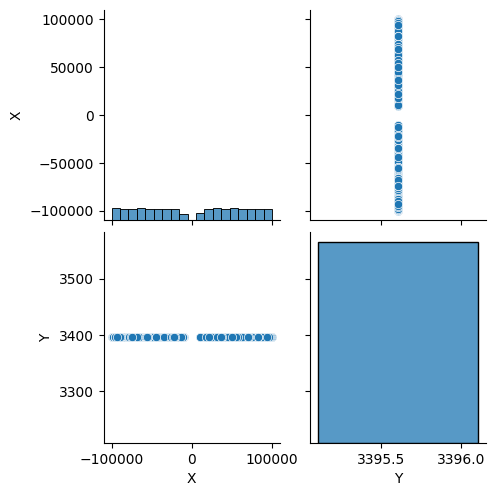

In [166]:
sns.pairplot(new_dataframe)

### this does not generalize to unseen data at all. 